## EDA

In [270]:
# Imports:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import export_text, DecisionTreeClassifier, plot_tree
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize

In [301]:
# Reading in dataset from webscraping:
climate = pd.read_csv('./data/cc_posts.csv')
climate.head(3)

,title,score,id,subreddit,url,num_comments,body,created,date
0,Hurricane Harvey survivors only now getting ba...,1,x2md4s,climatechange,https://www.beaumontenterprise.com/news/articl...,0,NaN,1.661974e+09,2022-08-31 19:30:28
1,In what condition would the atmosphere have to...,0,x2emjd,climatechange,https://www.reddit.com/r/climatechange/comment...,5,What is currently happening in Earth is it's ...,1.661955e+09,2022-08-31 14:10:44
2,Has anyone here been personally affected by a ...,26,x27u36,climatechange,https://www.reddit.com/r/climatechange/comment...,21,"With what’s happened in Pakistan, ongoing wild...",1.661933e+09,2022-08-31 08:07:27


In [302]:
climate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10161 entries, 0 to 10160
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         10161 non-null  object 
 1   score         10161 non-null  int64  
 2   id            10161 non-null  object 
 3   subreddit     10161 non-null  object 
 4   url           10161 non-null  object 
 5   num_comments  10161 non-null  int64  
 6   body          4239 non-null   object 
 7   created       10161 non-null  float64
 8   date          10161 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 714.6+ KB


In [303]:
climate['num_comments'].describe()

count    10161.000000
mean        12.490306
std         20.334562
min          0.000000
25%          2.000000
50%          5.000000
75%         14.000000
max        274.000000
Name: num_comments, dtype: float64

In [304]:
(climate['num_comments'] == 0).sum()

121

In [305]:
# Since the problem statement concerns submissions that have at least 1 comment -> removing any posts w/ 0:
climate = climate[climate['num_comments'] != 0]
climate.num_comments.median()

5.0

#### Baseline:
The **median** comment length is 5, so we are looking to see what words/features of a title can garner a post with 6 or more comments. 
As a note - I am getting the median *before* doing the train-test split to have a cohesive comparison metric between both sets. 

In [306]:
# Create a new column that is a binary target - whether a post has greater than the mean (13 or more comments):
climate['abv_median'] = [1 if comment > 5 else 0 for comment in climate['num_comments']]
climate.head(3)

,title,score,id,subreddit,url,num_comments,body,created,date,abv_median
1,In what condition would the atmosphere have to...,0,x2emjd,climatechange,https://www.reddit.com/r/climatechange/comment...,5,What is currently happening in Earth is it's ...,1.661955e+09,2022-08-31 14:10:44,0
2,Has anyone here been personally affected by a ...,26,x27u36,climatechange,https://www.reddit.com/r/climatechange/comment...,21,"With what’s happened in Pakistan, ongoing wild...",1.661933e+09,2022-08-31 08:07:27,1
3,A prolonged and record heat wave builds over t...,54,x1y1kh,climatechange,https://www.cnn.com/2022/08/30/weather/record-...,10,NaN,1.661902e+09,2022-08-30 23:33:35,1


In [307]:
climate['abv_median'].value_counts(normalize=True)

0    0.525199
1    0.474801
Name: abv_median, dtype: float64

#### Interpretation:
Our model has to predict better than just predicting the majority class - which is that a post has 5 or fewer comments (52.5% of posts).

In [308]:
# Getting the length of the title as a new column:
climate['title_len'] = [len(title) for title in climate['title']]
climate.head(3)

,title,score,id,subreddit,url,num_comments,body,created,date,abv_median,title_len
1,In what condition would the atmosphere have to...,0,x2emjd,climatechange,https://www.reddit.com/r/climatechange/comment...,5,What is currently happening in Earth is it's ...,1.661955e+09,2022-08-31 14:10:44,0,91
2,Has anyone here been personally affected by a ...,26,x27u36,climatechange,https://www.reddit.com/r/climatechange/comment...,21,"With what’s happened in Pakistan, ongoing wild...",1.661933e+09,2022-08-31 08:07:27,1,69
3,A prolonged and record heat wave builds over t...,54,x1y1kh,climatechange,https://www.cnn.com/2022/08/30/weather/record-...,10,NaN,1.661902e+09,2022-08-30 23:33:35,1,69


### Visualizations:

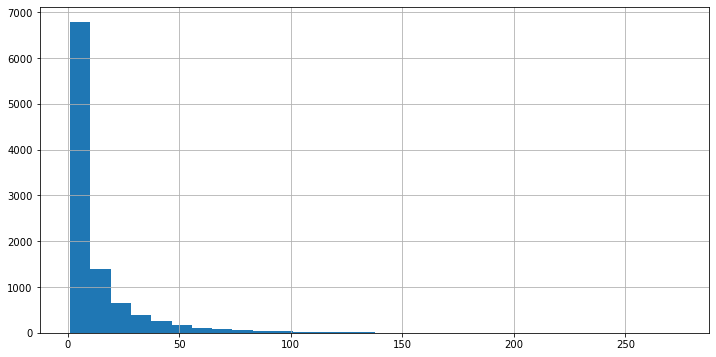

In [309]:
# Looking at distribution of number of comments:
climate['num_comments'].hist(figsize=(12,6), bins=30);

**Interpretation** - very right skewed. I'll explore outliers, but I don't necessarily want to remove them if they are valid because the most highly commented posts could be have very relevant information in them as to what makes a post popular.

In [310]:
climate['num_comments'].describe()

count    10040.000000
mean        12.640837
std         20.410175
min          1.000000
25%          2.000000
50%          5.000000
75%         14.000000
max        274.000000
Name: num_comments, dtype: float64

In [311]:
# This is an example of what trimming the upper range of comments could look like, but I won't do that yet.
climate['num_comments'].mean() + (climate['num_comments'].std() * 3)

73.8713615594476

In [312]:
# Looking at text for most commented on posts:
climate.sort_values(by='num_comments', ascending=False)[:10]

,title,score,id,subreddit,url,num_comments,body,created,date,abv_median,title_len
841,"""Human activity causes global warming"" is not ...",0,temoug,climatechange,https://www.reddit.com/r/climatechange/comment...,274,"In order for a hypothesis to be scientific, it...",1.647343e+09,2022-03-15 11:19:59,1,54
1505,99.9% agree climate change caused by humans,1,qcv08l,climatechange,https://iopscience.iop.org/article/10.1088/174...,268,NaN,1.634832e+09,2021-10-21 15:59:30,1,43
365,Debating climate change skeptic and he throws ...,116,vqqiv4,climatechange,https://i.redd.it/21vqzlh6hg991.jpg,250,NaN,1.656881e+09,2022-07-03 20:39:22,1,77
468,When did the climate warm near as fast or even...,34,vc0k6v,climatechange,https://www.reddit.com/r/climatechange/comment...,247,In a debate about climate change online someon...,1.655203e+09,2022-06-14 10:37:31,1,72
9634,A 50th anniversary few remember: LBJ's warning...,2,2vsmmw,climatechange,http://www.dailyclimate.org/tdc-newsroom/2015/...,241,NaN,1.423855e+09,2015-02-13 19:15:25,1,64
96,Hunger Stones? Climate Change?,20,wqh1tk,climatechange,https://www.reddit.com/r/climatechange/comment...,225,Just saw on the news that the drought facing E...,1.660716e+09,2022-08-17 05:57:01,1,30
1494,If climate change happened during earth time s...,1,qdmn1e,climatechange,https://www.reddit.com/r/climatechange/comment...,220,NaN,1.634926e+09,2021-10-22 18:05:31,1,127
6479,I'm afraid climate change is going to kill me!...,1,aqdmbz,climatechange,https://www.reddit.com/r/climatechange/comment...,208,Feeling scared? Have you been listening to or ...,1.550104e+09,2019-02-14 00:22:32,1,52
142,"""What did they do when they had hot summers 50...",73,wki5hn,climatechange,https://www.reddit.com/r/climatechange/comment...,202,"Hello, \n\nI have a family member who doesn't ...",1.660088e+09,2022-08-09 23:36:06,1,58
9639,Study: Global warming skeptics know more about...,0,2vq2bz,climatechange,http://www.foxnews.com/science/2015/02/12/stud...,200,NaN,1.423795e+09,2015-02-13 02:37:27,1,62


In [313]:
# Looking at shortest titles: 
climate.sort_values(by='title_len')[:10]

,title,score,id,subreddit,url,num_comments,body,created,date,abv_median,title_len
4014,y,2,d9l5xl,climatechange,https://i.redd.it/rt8tuscdiyo31.png,1,NaN,1.569512e+09,2019-09-26 15:27:38,0,1
128,GBR,4,wm5bga,climatechange,https://www.reddit.com/r/climatechange/comment...,9,I've argued here at times about the reported n...,1.660260e+09,2022-08-11 23:15:55,1,3
4797,Hi!,1,g4jla2,climatechange,https://www.reddit.com/r/climatechange/comment...,6,I’m making a list on what climate change will ...,1.587346e+09,2020-04-20 01:22:18,1,3
2608,Hmmm,1,o34mxf,climatechange,https://i.redd.it/eosvjziwe4671.jpg,1,NaN,1.624064e+09,2021-06-19 00:55:12,0,4
5577,hmmm,5,dytujx,climatechange,https://i.redd.it/b900h0k5mqz31.jpg,2,NaN,1.574210e+09,2019-11-20 00:39:35,0,4
4574,Sad.,1,f16juw,climatechange,https://i.redd.it/0m72csfacvf41.jpg,7,NaN,1.581241e+09,2020-02-09 09:39:26,1,4
6762,Fear,1,bmbvp7,climatechange,https://www.reddit.com/r/climatechange/comment...,10,Climate Change is something that terrifies me ...,1.557355e+09,2019-05-08 22:34:16,1,4
6502,Kids,1,aofvsv,climatechange,https://www.reddit.com/r/climatechange/comment...,10,Should I have kids? I know every new person co...,1.549628e+09,2019-02-08 12:05:19,1,4
8268,PETM,0,99dacy,climatechange,https://www.reddit.com/r/climatechange/comment...,2,I’ve seen it suggests that the global temperat...,1.534944e+09,2018-08-22 13:22:09,0,4
4031,halp,0,d9bru6,climatechange,https://i.redd.it/99twh0k9yto31.png,3,NaN,1.569456e+09,2019-09-26 00:07:34,0,4


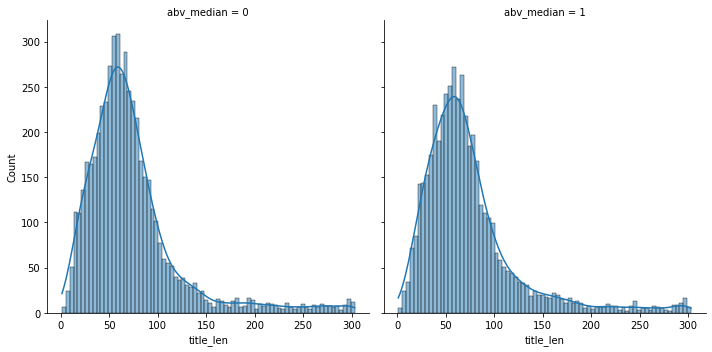

In [314]:
# Title length by whether above or below median:
sns.displot(data=climate, x="title_len", kde=True, col='abv_median');

In [329]:
# trial for removing highest len comments:
climate = climate[climate['title_len'] < 200]

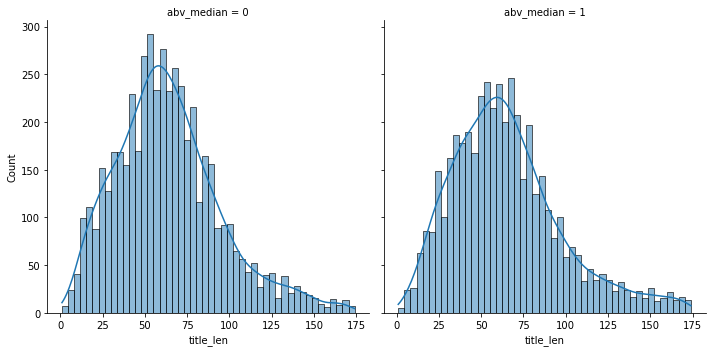

In [316]:
sns.displot(data=climate, x="title_len", kde=True, col='abv_median');

In [317]:
climate.shape

(9518, 11)

## Cleaning the text in 'title' data:
1) Normalization
2) Stop words
3) Stemming
4) Lemmatization
5) Part of Speech (POS) tagging and chunking

(inspiration from [this blog post](https://medium.com/towards-data-science/text-cleaning-methods-for-natural-language-processing-f2fc1796e8c7))

### 1. Normalization:

Remove the 'noise'(non alpha-numeric characters) and lowercase words:

In [318]:
# References from documentation: https://docs.python.org/3/howto/regex.html
import re

def  clean_text(df, text_field, new_text_field_name):
    # lowercase text
    df[new_text_field_name] = df[text_field].str.lower()
    # remove any non alpha-numeric characters
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    # remove numbers
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"\d+", "", elem))
    
    return df
data_clean = clean_text(climate, 'title', 'title_clean')

In [319]:
data_clean['title_clean'].iloc[888]

'burnt by the sun bolivias highlands sizzle under fierce uv rays'

In [320]:
import nltk 
from nltk.tokenize import sent_tokenize, word_tokenize
data_clean['title_tokens'] = data_clean['title_clean'].apply(lambda x: word_tokenize(x))
data_clean.head(3)

,title,score,id,subreddit,url,num_comments,body,created,date,abv_median,title_len,title_clean,title_tokens
1,In what condition would the atmosphere have to...,0,x2emjd,climatechange,https://www.reddit.com/r/climatechange/comment...,5,What is currently happening in Earth is it's ...,1.661955e+09,2022-08-31 14:10:44,0,91,in what condition would the atmosphere have to...,"[in, what, condition, would, the, atmosphere, ..."
2,Has anyone here been personally affected by a ...,26,x27u36,climatechange,https://www.reddit.com/r/climatechange/comment...,21,"With what’s happened in Pakistan, ongoing wild...",1.661933e+09,2022-08-31 08:07:27,1,69,has anyone here been personally affected by a ...,"[has, anyone, here, been, personally, affected..."
3,A prolonged and record heat wave builds over t...,54,x1y1kh,climatechange,https://www.cnn.com/2022/08/30/weather/record-...,10,NaN,1.661902e+09,2022-08-30 23:33:35,1,69,a prolonged and record heat wave builds over t...,"[a, prolonged, and, record, heat, wave, builds..."


In [321]:
def word_stemmer(text):
    stem_text = [PorterStemmer().stem(i) for i in text]
    return stem_text
data_clean['title_tokens_stem'] = data_clean['title_tokens'].apply(lambda x: word_stemmer(x))
data_clean.head(3)

,title,score,id,subreddit,url,num_comments,body,created,date,abv_median,title_len,title_clean,title_tokens,title_tokens_stem
1,In what condition would the atmosphere have to...,0,x2emjd,climatechange,https://www.reddit.com/r/climatechange/comment...,5,What is currently happening in Earth is it's ...,1.661955e+09,2022-08-31 14:10:44,0,91,in what condition would the atmosphere have to...,"[in, what, condition, would, the, atmosphere, ...","[in, what, condit, would, the, atmospher, have..."
2,Has anyone here been personally affected by a ...,26,x27u36,climatechange,https://www.reddit.com/r/climatechange/comment...,21,"With what’s happened in Pakistan, ongoing wild...",1.661933e+09,2022-08-31 08:07:27,1,69,has anyone here been personally affected by a ...,"[has, anyone, here, been, personally, affected...","[ha, anyon, here, been, person, affect, by, a,..."
3,A prolonged and record heat wave builds over t...,54,x1y1kh,climatechange,https://www.cnn.com/2022/08/30/weather/record-...,10,NaN,1.661902e+09,2022-08-30 23:33:35,1,69,a prolonged and record heat wave builds over t...,"[a, prolonged, and, record, heat, wave, builds...","[a, prolong, and, record, heat, wave, build, o..."


In [322]:
data_clean['stem_string'] = [' '.join(i) for i in data_clean['title_tokens_stem']]
data_clean['stem_string']

1        in what condit would the atmospher have to be ...
2        ha anyon here been person affect by a major cl...
3        a prolong and record heat wave build over the ...
4        graph that illustr chang in major weather even...
5            start a geolog class teacher deni global warm
                               ...                        
10156                      a truth tabl about climat chang
10157    climat chang studi tie recent heat wave to glo...
10158                                                activ
10159                 i found a theme song for your reddit
10160    pleas read the sidebar of thi subreddit befor ...
Name: stem_string, Length: 9518, dtype: object

In [323]:
# Creating a new dataframe with most relevant info:
key_climate = data_clean[['stem_string', 'title_len', 'id', 'abv_median']]
key_climate.head(3)

,stem_string,title_len,id,abv_median
1,in what condit would the atmospher have to be ...,91,x2emjd,0
2,ha anyon here been person affect by a major cl...,69,x27u36,1
3,a prolong and record heat wave build over the ...,69,x1y1kh,1


In [324]:
key_climate['abv_median'].value_counts()

0    4993
1    4525
Name: abv_median, dtype: int64

## Modeling:

In [325]:
# random_forest_params = {
#     'max_depth' : [None, 5, 10],
#     'min_samples_leaf': [2, 3, 5],
#     'n_estimators': [100, 125, 150]
    
# }

# gs = GridSearchCV(
#     RandomForestClassifier(), param_grid=random_forest_params, verbose=1)

# gs.fit(X_train_cv, y_train)

# print(gs.best_score_, gs.best_params_)

# gs.score(X_train_cv, y_train), gs.score(X_test_cv, y_test)

**results** from Gridsearch: Fitting 5 folds for each of 27 candidates, totalling 135 fits

0.5822045152722444 {'max_depth': None, 'min_samples_leaf': 3, 'n_estimators': 100}

(0.7698539176626826, 0.5828685258964144)


In [326]:
X = key_climate['stem_string']
y = key_climate['abv_median']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=.75, random_state=42)

# cv = CountVectorizer(stop_words='english', binary=True, ngram_range=(1,2))
cv= CountVectorizer()
cv.fit(X_train)

X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)

In [327]:
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train_cv, y_train)
dtc.score(X_train_cv, y_train), dtc.score(X_test_cv, y_test)

(0.9957971420565985, 0.5529411764705883)

In [328]:
rfc = RandomForestClassifier(random_state=42, min_samples_leaf=3, n_estimators=150)
rfc.fit(X_train_cv, y_train)
rfc.score(X_train_cv, y_train), rfc.score(X_test_cv, y_test)

(0.7597366209022135, 0.5991596638655462)

In [298]:
abc = AdaBoostClassifier(random_state=42, n_estimators=150)

abc.fit(X_train_cv, y_train)
abc.score(X_train_cv, y_train), abc.score(X_test_cv, y_test)

(0.6513457556935818, 0.6001655629139073)

scores from text_clean, ngram_range(1,2)
DTC: .996 .531
RFC: .765 .598
ABC: .676 .603

scores from text_clean, stop_words='english', binary=True, ngram_range=(1,2):
DTC: .993 .558
RFC: .756 .580
ABC: .646 .555

scores from stem_string, all default:
DTC: .996 .549
RFC: .765 .604
ABC: .670 .600

scores from stem_string, ngram_range=(1,2)
DTC: .996 .548
RFC: .770 .609
ABC: .674 .596

In [299]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression


pipe = Pipeline([
    ('cv', CountVectorizer(ngram_range=(1,2))),
    ('lr', LogisticRegression(max_iter=1000)),
])

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.9857832988267771, 0.6047185430463576)